# QVEC

This notebook is a replication of Tsvetkov et al. (2015) _Evaluation of Word Vector Representations by Subspace Alignment_, which introduces QVEC. QVEC is an intrinsic evaluation method of word embeddings, measuring the correlation between dimensions of the embeddings and linguistic features. The original code is [available](https://github.com/ytsvetko/qvec), but I'm replicating it for two reasons: i) as a learning exercise and ii) the original implementation looks messy.

To implement QVEC, I'm going to need two things:
- Gold standard linguistic features
- The QVEC model

## Linguistic features

### SemCor

The linguistic features used in the original paper come from SemCor, a WordNet annotated subset of the Brown corpus. WordNet has coarse features for nouns and verbs, called "supersenses". These are things like "NOUN.BODY", "VERB.MOTION". Supersenses are coarse semantic features, given by linguists. Once downloaded, NLTK provides easy access to the SemCor corpus, in particular as a stream of tagged chunks. Chunks are coarse constituents.

In [1]:
import pandas as pd
from nltk.corpus import semcor
from nltk.corpus.reader.wordnet import Lemma

In [2]:
tagged_chunks = semcor.tagged_chunks(tag='both')
tagged_chunks = list(tagged_chunks) # takes ages

Put the tagged chunks into a `pandas dataframe`. Each row holds a chunk, and I will add columns as I go on.

In [3]:
sc = pd.DataFrame({'chunk': tagged_chunks})

These functions correspond to the columns I want to add.

In [5]:
def extract_words(tc):
    """Return the words of a tagged chunk."""
    words = [w.lower() for w in tc.leaves()]
    return ' '.join(words)

def extract_pos(tc):
    """
    Return the POS of a tagged chunk.
    
    This isn't the cleanest way, but it works for now.
    """
    return tc.pos()[0][1]

def extract_supersense(tc):
    """
    Return the supersense of a tagged chunk, otherwise None.
    
    Only nouns and verbs have supersenses.
    """
    label = tc.label()
    if isinstance(label, Lemma):
        return label.synset().lexname()
    return None

def extract_rough_pos(supersense):
    """Return coarser POS from supersense information."""
    if supersense:
        return supersense.split('.')[0]
    return None

Add the columns.

In [6]:
sc['words'] = sc['chunk'].apply(extract_words)
sc['pos'] = sc['chunk'].apply(extract_pos)
sc['supersense'] = sc['chunk'].apply(extract_supersense)
sc['rough_pos'] = sc['supersense'].apply(extract_rough_pos)

In [7]:
sc.to_csv('semcor.csv')

Only nouns and verbs have supersenses in WordNet (adjectives do, but they seem to be ignored in the original paper). We only care about words that have supersenses now. Also, there's a lot of junk words in SemCor. First we replace all digits with '0'. Then we'll drop words that are i) not alphabetic or '0' or ii) multiple words. I can't tell how this is done in the original paper, so I may get slightly different results.

In [8]:
sc = sc[sc['rough_pos'].isin(['noun', 'verb'])]
sc.loc[sc['words'].str.isdigit(), 'words'] = '0'
sc = sc[(sc['words'].str.isalpha()) | (sc['words'].str.match('0'))]

The linguistic features are in fact a distribution over the 41 supersenses.

In [9]:
grouped = sc.groupby('words')
features = grouped['supersense'].value_counts(normalize=True).unstack()
features['count_in_semcor'] = grouped['supersense'].count()
features.reset_index(inplace=True) # make "words" a column not the index
features.fillna(0, inplace=True)
features.columns.name = ''

Now we restrict to words with a certain frequency in the corpus. The original paper has 4199 words when thresholding at a frequency of 5, I get 4847. I believe this discrepancy comes from how words are preprocessed.

In [10]:
threshold = 5
subset = features[features['count_in_semcor'] > threshold]
print('Number of words:', len(subset))

Number of words: 4847


### Comparing with reference implementation

I want to know how different my linguistic features are from the original paper's, available [here](https://github.com/ytsvetko/qvec/blob/master/oracles/semcor_noun_verb.supersenses.en). Read in the original paper's. Note that their columns start with "semcor.", which will be helpful when I merge the two sets.

In [32]:
words, dicts = [], []
with open('tsvetkov.txt', 'r') as f:
    for line in f:
        word, _, d = line.partition('\t')
        words.append(word)
        d = eval(d.strip())
        dicts.append(d)

tsvetkov = pd.DataFrame(dicts)
tsvetkov['words'] = words
tsvetkov.fillna(0, inplace=True)

Merge the two sets. This dataframe has 84 columns: one for the word, one for my count in SemCor, 41 for my features, 41 for their features.

In [12]:
comparison = pd.merge(features, tsvetkov, on=['words'], how='inner')
comparison.head()

,words,noun.Tops,noun.act,noun.animal,noun.artifact,noun.attribute,noun.body,noun.cognition,noun.communication,noun.event,...,semcor.verb.consumption,semcor.verb.contact,semcor.verb.creation,semcor.verb.emotion,semcor.verb.motion,semcor.verb.perception,semcor.verb.possession,semcor.verb.social,semcor.verb.stative,semcor.verb.weather
0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,a,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,abandon,0.0,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.0,0.0
3,ability,0.0,0.0,0.0,0.0,0.727273,0.0,0.272727,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,abolish,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0


So I have two discrete distributions, and I want to know how different/similar they are. I need to ask someone how to do this properly, but I have a few naive ideas.

#### KL divergence

In [13]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Sort the columns so that features in the two lists are in the same position.

In [14]:
their_columns = sorted([c for c in comparison.columns if c.startswith('semcor')])
my_columns = [c.partition('.')[2] for c in their_columns]

def KL(row):
    """
    Helper function for apply KL to a dataframe.
    
    I get errors unless I explicitly convert to float, even though they appear to be floats anyway
    """
    theirs = row[their_columns].values.astype(float)
    mine = row[my_columns].values.astype(float)
    return stats.entropy(theirs, mine)

In [15]:
comparison['KL'] = comparison.apply(KL, axis=1)

`Inf` is not good, meaning that the two distributions are very different. Nearly half of the words have very different distributions.

In [16]:
np.isinf(comparison['KL']).sum() / len(comparison)

0.46724565756823822

Otherwise, most words have similar distributions.

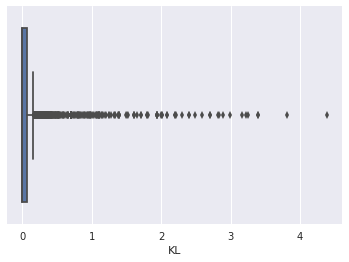

In [17]:
sns.boxplot(comparison[np.isfinite(comparison['KL'])]['KL']);

My linguistic features are obviously not similar enough to the original paper's, and that needs to be fixed. I'm putting that aside at the moment and proceding *as if* the linguistic features I have are correct.

In [33]:
subset = tsvetkov
subset.columns = [c.replace('semcor.', '') for c in subset.columns]

## QVEC model

QVEC finds an alignment between dimensions of learnt word embeddings and dimensions (features) of linguistic features by maximising the cumulative correlation.

$N$ is the size of the vocabulary (in common between the embeddings and the linguistic features).

$D$ is the dimensionality of the embeddings.

$X \in \mathbb{R}^{D \times N}$ is the matrix of embeddings. Note that a word's embedding is a column, rows are individual dimensions.

$P$ is the number of linguistic features.

$S \in \mathbb{R}^{P \times N}$ is the matrix of linguistic features, created above. Again, each word is a column and rows are individual features.

QVEC finds an alignment between the rows of $X$ and the rows of $S$ that maximises the correlation between the aligned rows. Each row of $X$ is aligned to **at most** one row of $S$, but each row of $S$ **may** be aligned to more than one row of $X$.

$A \in \{0,1\}^{D \times P}$ holds the alignments. $x_{ij}$ is 1 if dimension $i$ of $X$ is aligned with linguistic feature $j$.

The sum of correlations (which can be arbitrarily large with more dimensions or features) is their measure of the quality of the word embeddings in $X$.

$QVEC = \max_{A|\sum_{j}a_{ij} \leq 1}\sum_{i=1}^{D}\sum_{j=1}^{P}r(x_i, s_j) \times a_{ij}$

In words, for any possible alignment $A$, subject to the constraint that each embedding dimension is aligned to 0 or 1 linguistic features, sum up the correlations. The sum for the best alignment is the measure of the embeddings.

Crucially, this assumes that the dimensions of the embeddings end up encoding linguistic features. The authors justify this by the effectiveness of using word embeddings in linear models in downstream tasks.

First things first, transform my linguistic features into the format mentioned above (i.e., the matrix $S$).

In [35]:
subset.set_index('words', inplace=True)
#subset.drop('count_in_semcor', inplace=True, axis=1)
subset = subset.T

In [36]:
subset.head()

words,0,a,abandon,ability,abolish,absence,absorb,absorption,abstract,abstraction,...,yes,yesterday,yield,yokuts,york,young,youth,yr,zero,zinc
noun.Tops,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.0
noun.act,0.0,0.0,0.000000,0.000000,0.0,0.25,0.0,0.0,0.000000,0.250000,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.0
noun.animal,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.304348,0.00,0.0,0.0,0.0
noun.artifact,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.272727,0.166667,...,0.0,0.0,0.16,0.0,0.0,0.000000,0.00,0.0,0.0,0.0
noun.attribute,0.0,0.0,0.035714,0.703704,0.0,0.00,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.000000,0.08,0.0,0.0,0.0


### Learnt word embeddings

The original paper trains various different models of varying sizes. At a later stage I could do that, but for now I'm happy with using pre-trained embeddings.

In [37]:
import csv
size = 300
fname = '../adl-hatespeech-2017/python/embeddings/glove.6B.{}d.txt'.format(size)
embeddings = pd.read_csv(fname, sep=' ', header=None, index_col=0, quoting=csv.QUOTE_NONE).T
embeddings.head()

,the,",",.,of,to,and,in,a,"""",'s,...,sigarms,katuna,aqm,1.3775,corythosaurus,chanty,kronik,rolonda,zsombor,sandberger
1,0.046560,-0.255390,-0.125590,-0.076947,-0.257560,0.038466,-0.44399,-0.297120,0.694700,-0.001272,...,0.14649,-0.030013,0.46348,0.71376,0.886490,0.392700,0.136790,0.075713,0.81451,0.429191
2,0.213180,-0.257230,0.013630,-0.021211,-0.057132,-0.039792,0.12817,0.094049,0.221840,0.365140,...,-0.47266,0.246260,-0.42811,-0.56625,-0.095745,-0.022505,-0.139090,-0.040502,-0.36221,-0.296897
3,-0.007436,0.131690,0.103060,0.212710,-0.671900,0.082747,-0.25247,-0.096662,0.105260,-0.077363,...,0.17144,0.068192,0.45750,-0.18468,0.189610,0.304580,-0.360890,0.183450,0.31186,0.150110
4,-0.458540,-0.042688,-0.101230,-0.722320,-0.380820,-0.389230,-0.18582,-0.344000,0.012382,-0.265590,...,0.26431,0.089033,0.25317,0.30104,0.012919,0.187990,0.079864,0.512300,0.81381,0.245201
5,-0.035639,0.218170,0.098128,-0.139880,-0.364210,-0.214310,-0.16614,-0.184830,-0.255800,0.179870,...,-0.13895,-0.199770,0.58327,-0.56443,-0.409250,0.141180,0.321490,-0.228560,0.18852,-0.003520


In [39]:
common_words = embeddings.columns.intersection(subset.columns)
embeddings = embeddings[common_words]
embeddings.to_csv('glove_embeddings.csv')

The Python variables S and X refer to $S$ and $X$ exactly as above.

In [40]:
S = subset[common_words]
X = embeddings[common_words]

Now we want the correlation between the rows of S and the rows of X. This may not be the easiest way to do it but it works.

In [41]:
correlations = pd.DataFrame({i:X.corrwith(S.iloc[i], axis=1) for i in range(len(S))})
correlations.columns = S.index

For each row of this correlation matrix (i.e. for each of the dimenions of the embeddings), we want the linguistic feature that it is most correlated with. We also get the value of that correlation.

In [42]:
alignments = correlations.idxmax(axis=1)
correlations.max(axis=1).head()

1    0.103305
2    0.079669
3    0.132868
4    0.118316
5    0.073610
dtype: float64

The score of the embeddings relative to the linguistic features is the sum of the maximum correlations. Note how this value depends on how many dimensions in the embeddings there are. For 300 dimension vectors trained (by them) from GloVe, the authors get 34.4, while I get 32.4. Note that our linguistic features are still different, so the fact that the discrepancy here is not too big is encouraging.

In [43]:
qvec = correlations.max(axis=1).sum()
qvec

33.937268703923273

We don't really need it, but just to be explicit let's get the matrix $A$ of alignments.

In [44]:
A = pd.DataFrame(0, index=range(len(X)), columns=S.index)
for dim, feat in alignments.iteritems():
    A[feat][dim] = 1

In [45]:
A.head()

,noun.Tops,noun.act,noun.animal,noun.artifact,noun.attribute,noun.body,noun.cognition,noun.communication,noun.event,noun.feeling,...,verb.consumption,verb.contact,verb.creation,verb.emotion,verb.motion,verb.perception,verb.possession,verb.social,verb.stative,verb.weather
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The rest of the paper is a series of experiments training large models and evaluating them on both instrinic and extrinsic tasks, including QVEC. I'm not going to replicate that here, but the QVEC implementation is complete.

## Exploring QVEC

I want to spend some time now looking closer at QVEC's output, namely the correlations and the alignment matrix. The second main point of the original paper is that the alignments allow you to interpret individual dimensions of embeddings.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### On average, how correlated are the dimensions with the linguistic features?

This plot suggests "not really". In fact it looks very normal. That is, on average there is **no** correlation between the dimensions of a word embedding and linguistic features.

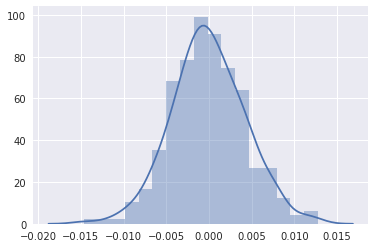

In [47]:
sns.distplot(correlations.mean(axis=1));

#### What do the maximum correlations look like?

These are all positive. But are they different enough from 0? What test can I use here?

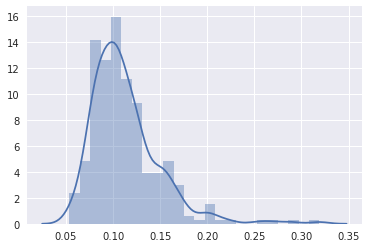

In [48]:
sns.distplot(correlations.max(axis=1));

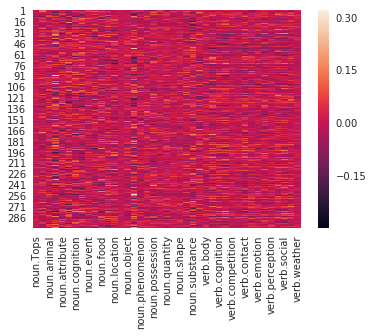

In [51]:
sns.heatmap(correlations);

## Canonical Correlation Analysis

In a follow-up 2016 paper, a subset of the original authors introduce QVEC-CCA. It's really just QVEC except instead of summing the highest row-wise correlations, they use canonical correlation analysis. I didn't know what that was, but after reading a bit I have a reasonable grasp of it. I'm going to replicate that 2016 paper, or at least the most important part of it which is the use of CCA. Note that the other new thing in the 2016 paper is the use of syntactic features, in addition to semantic, which I won't do right now.

Scikit-learn has an implementation of CCA. It took me a while to figure out what are the learnt parameters that I want, and I'm only 80% confident I have it right.

In [31]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=1)
cca = cca.fit(X.T, S.T)

I believe the linear combinations I want are stored in the `x_weights_` and `y_weights_` attributes.

In [32]:
a = np.dot(X.T, cca.x_weights_)
b = np.dot(S.T, cca.y_weights_)
stats.pearsonr(a, b)

(array([ 0.74860902]), array([ 0.]))

## Todo
- Use different linguistic features (semantic, syntactic, etc.)
- Use different correlation metric
- Explore the correlations, alignments and top k words more
- Levin's verb classification

## Explore correlations, alignments and top k words

#### Top K words
In the paper they give the top K words for a dimension. The code prints, for each dimension, the dimension number, the aligned linguistic feature, the correlation between the two previous things, and the top k words associated with the dimension. I understand the last bit to mean "the k words with the highest value in the dimension".

In [53]:
k = 50
top_k = pd.DataFrame(alignments, columns=['feature'])
top_k['correlation'] = correlations.max(axis=1)
tmp = pd.DataFrame([embeddings.loc[i].nlargest(n=k).index for i in top_k.index])
top_k = pd.merge(top_k, tmp, left_index=True, right_index=True)

In [74]:
top_k.head()

,feature,correlation,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
1,noun.act,0.103305,marksman,football,goal,chromatography,bowl,feedlot,additive,mg,...,liter,coach,rifle,kick,range,species,equilibrium,defense,qualification,unit
2,noun.food,0.079669,binomial,cancer,retirement,resentment,breast,anger,vector,escalation,...,apprentice,hazard,redcoat,chaos,divan,sky,commander,transit,rebel,ray
3,noun.act,0.132868,hr,creep,sneak,average,deduction,pound,expire,procreation,...,hop,regulate,tax,errand,nickel,fee,pill,estimate,psychologist,record
4,noun.time,0.118316,checkbook,diet,witch,contraceptive,stimulate,excite,imagination,flask,...,budget,impulse,calcium,robber,concentrate,resource,contact,inspire,donor,advice
5,noun.person,0.073610,mm,draft,summary,ages,size,brood,pool,africa,...,span,edition,america,effectiveness,probability,baseball,age,catcher,perish,europe


Most of these top words seem like junk. However, it'd be good to tease this apart a bit more. Here are some questions I'd like to ask:
- Are the top k words even of the right POS?
- Which features are missing (i.e. not the most correlated with any dimension)?
- How can I objectively measure whether the top k words are "correct"?

In [56]:
def get_dims(feature, df=top_k):
    """Return the dimensions aligned with `feature` in `df`."""
    return df[df['feature']==feature]

In [73]:
get_dims('noun.animal')

,feature,correlation,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
72,noun.animal,0.128498,pleura,deduct,cruise,vertex,diaphragm,mucosa,opening,rib,...,shakespeare,deduction,allowance,differentiation,broaden,uptake,l,repair,ultraviolet,protein
101,noun.animal,0.091112,vest,belt,slipper,cap,mm,column,tetrachloride,farming,...,stravinsky,whisky,birdie,truck,buckle,bubble,particle,salvation,plato,sweep
128,noun.animal,0.086233,member,sergeant,tolerate,positivist,merchant,hover,navy,crew,...,columbia,accuse,sheriff,bomber,physician,antagonism,weaken,native,slip,cent
134,noun.animal,0.101755,secede,stack,marshal,traverse,chimney,deck,log,blaze,...,amend,diet,code,catcher,cloud,carrier,battery,island,herd,oxygen
147,noun.animal,0.079551,bang,diagram,survey,pan,venus,rig,exploration,voyage,...,boil,examination,chromatography,see,photograph,railroad,epoch,scene,sewer,smoke
230,noun.animal,0.090885,twitch,wet,certify,knot,dipole,procurement,chain,towel,...,neutralist,neck,drugstore,disturbance,holster,tissue,veil,jab,fabric,rot


#### Which features are not the most correlated with any dimension?

In [75]:
subset.index.difference(top_k['feature'])

Index(['noun.Tops', 'noun.event', 'noun.motive', 'noun.relation',
       'verb.competition', 'verb.consumption', 'verb.perception',
       'verb.weather'],
      dtype='object')

#### FrameNet

- What is the appropriate way to use FrameNet resources as features?

In [79]:
from nltk.corpus import framenet as fn

In [113]:
fn.lus('happen.v')[1]

lexical unit (4886): happen.v

[definition]
  COD: take place, occur.

[frame] Event(187)

[POS] V

[status] Finished_Initial

[lexemes] happen/V

[semTypes] 0 semantic types

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/lu/lu4886.xml

[subCorpus] 13 subcorpora
  V-429-s20-lcoll-accident, V-429-s20-lcoll-what,
  V-429-s20-rcoll-if, V-680-s20-pass, V-730-s20-ppafter,
  V-730-s20-ppbefore, V-730-s20-ppin, V-780-s20-ppother,
  V-810-s20-pother, V-880-s20-intrans-simple,
  V-890-s20-intrans-adverb, V-900-s20-other, manually-added

[exemplars] 36 sentences across all subcorpora


In [106]:
tagged_chunks[:20]

[Tree('DT', ['The']),
 Tree(Lemma('group.n.01.group'), [Tree('NE', [Tree('NNP', ['Fulton', 'County', 'Grand', 'Jury'])])]),
 Tree(Lemma('state.v.01.say'), [Tree('VB', ['said'])]),
 Tree(Lemma('friday.n.01.Friday'), [Tree('NN', ['Friday'])]),
 Tree('DT', ['an']),
 Tree(Lemma('probe.n.01.investigation'), [Tree('NN', ['investigation'])]),
 Tree('IN', ['of']),
 Tree(Lemma('atlanta.n.01.Atlanta'), [Tree('NN', ['Atlanta'])]),
 Tree('POS', ["'s"]),
 Tree(Lemma('late.s.03.recent'), [Tree('JJ', ['recent'])]),
 Tree(Lemma('primary.n.01.primary_election'), [Tree('NN', ['primary', 'election'])]),
 Tree(Lemma('produce.v.04.produce'), [Tree('VB', ['produced'])]),
 Tree(None, ['``']),
 Tree('DT', ['no']),
 Tree(Lemma('evidence.n.01.evidence'), [Tree('NN', ['evidence'])]),
 Tree(None, ["''"]),
 Tree('IN', ['that']),
 Tree('DT', ['any']),
 Tree(Lemma('abnormality.n.04.irregularity'), [Tree('NN', ['irregularities'])]),
 Tree(Lemma('happen.v.01.take_place'), [Tree('VB', ['took', 'place'])])]